In [1]:
import numpy as np

**From the web**

In [16]:
#import generated data
data = np.load('X_array.npy').T
# X = X.T[:,0] 
# X1 = X.T[:,0]
N = data[:,0].size
C = 50

In [13]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
        .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias 

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in xrange(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_ext.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

NameError: name 'X0_ext' is not defined

In [ ]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_ext.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

**My own algorithm**

In [241]:
#Initialize parameters and functions
import numpy as np
import matplotlib.pyplot as plt


data = np.load('data.npy')
C = 50
learning_rate = 0.1
stopping_error = 1e-5
number_of_axis = data[0, :].size;
number_of_samples = data[:,0].size;

def plot_data(w0, b0, data):
    plt.figure() #Create a figure to plot multiple lines
    plt.grid()
    color = ["blue", "red"]
    for i in range(0, number_of_samples):
        if (data[i, number_of_axis - 1] > 0):
            try:
                color[i] = 'blue'
            except Exception as e:
                color.append('blue')
        else:
            try:
                color[i] = 'red'
            except Exception as e:
                color.append('red')
    plt.scatter(data[:,0], data[:,1], c = color )

    #Plot the center line
    line_points = np.zeros([100, 2])
    line_points[:, 0] = np.linspace(-1, 1, 100)
    line_points[:, 1] = -(w0[0] / w0[1])*line_points[:, 0] - b0
    plt.plot(line_points[:, 0], line_points[:, 1], label="Line with Normal Vector and Offset")

    #Plot the margin lines
    x_unit_vector = np.array([0, 1]);
    offset = abs((np.dot(w0, x_unit_vector)) / np.dot(w0, w0))

    margin_points_0 = np.zeros([100, 2])
    margin_points_0[:, 0] = np.linspace(-1, 1, 100)
    margin_points_0[:, 1] = -(w0[0] / w0[1])*margin_points_0[:, 0] - b0 - offset
    plt.plot(margin_points_0[:, 0], margin_points_0[:, 1], linestyle = '--')

    margin_points_1 = np.zeros([100, 2])
    margin_points_1[:, 0] = np.linspace(-1, 1, 100)
    margin_points_1[:, 1] = -(w0[0] / w0[1])*margin_points_1[:, 0] - b0 + offset
    plt.plot(margin_points_1[:, 0], margin_points_1[:, 1], linestyle = '--')



def support_vectors(w0, b0, data):
    error_set = np.zeros((0, number_of_axis)); #This is for it to work for all size of the data
    for i in range(0, number_of_samples - 1):
        xn = np.zeros((number_of_axis,1))
        xn = data[i, 0:number_of_axis-1].T  #Extract the vector and transpose the matrix
        dot_product = np.dot(w0, xn);
        if ((1 - data[i, number_of_axis - 1]*(dot_product + b0)) > 0):
            temp_xn = np.copy(data[i, 0:number_of_axis].T)
            temp_xn.resize((1,number_of_axis))
            error_set = np.append(error_set, temp_xn, axis = 0)
    return error_set

def gradient_w(w0, b0, data):
    error_set = support_vectors(w0, b0, data)
    grad_w = np.zeros((1, number_of_axis - 1));
    for i in range(0, error_set[:, 0].size - 1):
        grad_w += -(error_set[i, number_of_axis - 1] * error_set[i, 0:number_of_axis - 1])
    grad_w += (1/C) * w0
    return grad_w

def gradient_b(w0, b0, data):
    error_set = support_vectors(w0, b0, data)
    grad_b = 0;
    for i in range(0, error_set[:, 0].size - 1):
        grad_b += -error_set[i, number_of_axis - 1];
    grad_b += (1/C) * b0
    return grad_b
    
def cost_function(w0, b0, data):
    error_set = support_vectors(w0, b0, data)
    total_cost = 0;
    for i in range(0, error_set[:, 0].size - 1):
        total_cost += 1 - (error_set[i, number_of_axis - 1] * (np.dot(w0, error_set[i, 0:(number_of_axis - 1)])) + b0)
    total_cost += (1/(2*C)) * np.dot(w0, w0)
    return total_cost

def gradient_descent(w0, b0, data):
    w = w0
    b = b0
    iteration = 0
    for interation in range(0, 10000):
        w = w - learning_rate * gradient_w(w, b, data)
        b = b - learning_rate * gradient_b(w, b, data)
        if (cost_function(w, b, data) < stopping_error):
            break;            
    return w, b



3


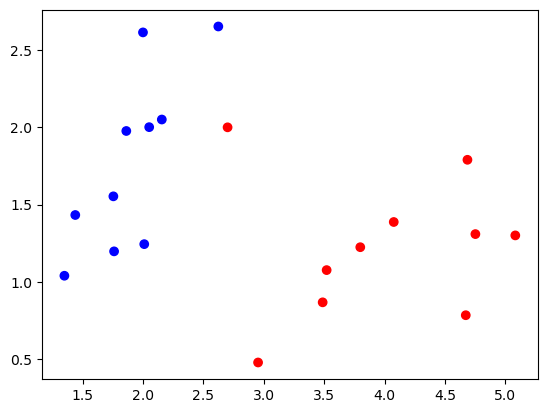

In [46]:
plot_data(data)


**Looking for the correct way to append value to a numpy array**

In [136]:
xn = data[0, 0:number_of_axis].T
print(xn)

[2.05084632 2.00111793 1.        ]


In [135]:
error_set = np.zeros((0, number_of_axis))
temp_xn = np.copy(xn)
temp_xn.resize((1,3))
error_set = np.append(error_set, temp_xn, axis = 0)
print(xn.shape)
print(error_set.shape)

(3,)
(1, 3)


**Testing the support vector function**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1 2]
dot product: 6.0530821815161
[[ 4.75215781  1.30969881 -1.        ]
 [ 4.67253811  0.78518512 -1.        ]
 [ 4.68638834  1.79005378 -1.        ]
 [ 3.48737994  0.86846079 -1.        ]
 [ 4.07611593  1.38790279 -1.        ]
 [ 2.95252573  0.47959209 -1.        ]
 [ 5.08269415  1.30126272 -1.        ]
 [ 3.52036329  1.07691292 -1.        ]
 [ 3.79891756  1.22491879 -1.        ]]


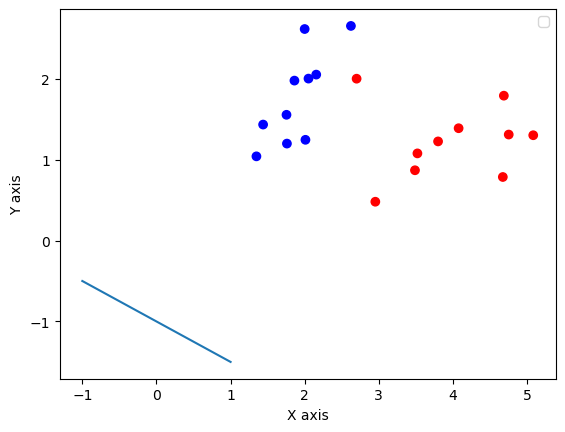

In [181]:
w0 = np.array([(1),(2)])
b0 = 1
xn =  np.copy(data[0, 0:2])
print(w0)
print(f"dot product: {np.dot(xn,w0)}")

print(support_vectors(w0, b0, data))


#Plotting the function with w0 and b and data
plt.figure()
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.legend()
plot_data(data)

normal_vector = w0.T
point_on_line = np.array([0, -b0])
t = np.linspace(-1, 1, 100)
line_points = np.zeros([100,2]);
for i in range(0, t.size):
    line_points[i, 0] = t[i]
    line_points[i,1] = -(normal_vector[0] / normal_vector[1])*t[i] - b0

plt.plot(line_points[:, 0], line_points[:, 1], label="Line with Normal Vector and Offset")

**Multiple plot on the same figure**

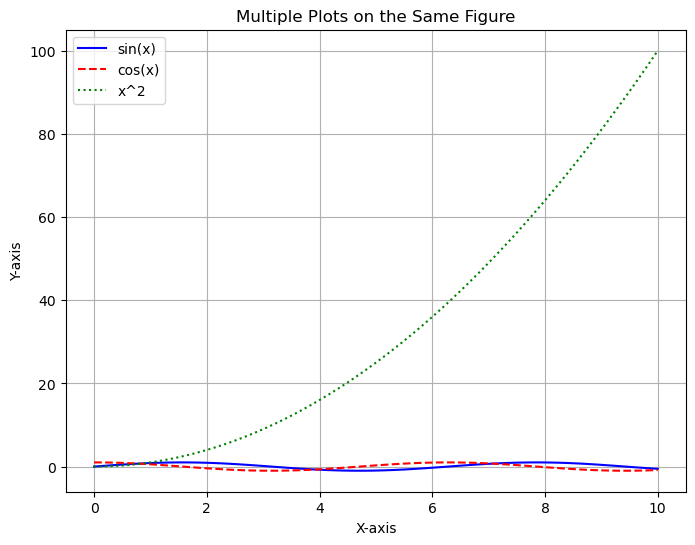

In [169]:
# Sample data for plotting
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = x**2

# Create a new figure and axis
plt.figure(figsize=(8, 6))

# Plot the first curve (sin(x))
plt.plot(x, y1, label='sin(x)', color='blue', linestyle='-')

# Plot the second curve (cos(x))
plt.plot(x, y2, label='cos(x)', color='red', linestyle='--')

# Plot the third curve (x^2)
plt.plot(x, y3, label='x^2', color='green', linestyle=':')

# Add labels, title, and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Plots on the Same Figure')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

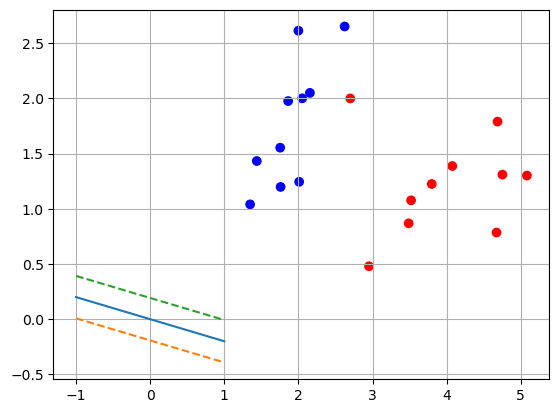

In [215]:
plot_data((1,5), 0, data)

**Test gradient_w function**

In [218]:
error_set = support_vectors(w0, b0, data)
grad_w = np.zeros((1, number_of_axis - 1))
for i in range(0, error_set[:, 0].size - 1):
    grad_w += -(error_set[i, number_of_axis - 1] * error_set[i, 0:number_of_axis - 1])
grad_w += (1/C) * w0

In [217]:
error_set.size

27

**Test gradient_b function**

In [221]:
error_set = support_vectors(w0, b0, data)
grad_b = 0;
for i in range(0, error_set[:, 0].size - 1):
    grad_b += -error_set[i, number_of_axis - 1];
grad_b += (1/C) * b0

In [222]:
print(grad_b)

8.02


**Test cost function**

In [234]:
error_set = support_vectors(w0, b0, data)
total_cost = 0;
for i in range(0, error_set[:, 0].size - 1):
    total_cost += 1 - (error_set[i, number_of_axis - 1] * (np.dot(w0, error_set[i, 0:(number_of_axis - 1)])) + b0)
total_cost += (1/(2*C)) * np.dot(w0, w0)
print(total_cost)

51.27830132044304


**Testing gradient descent function**

In [242]:
w = np.copy(w0)
b = b0
iteration = 0
for interation in range(0, 10000):
    w = w - learning_rate * gradient_w(w, b, data)
    b = b - learning_rate * gradient_b(w, b, data)    
    if (cost_function(w, b, data) < stopping_error):
        break; 

ValueError: shapes (1,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)